In [398]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.ndimage import gaussian_filter
import imageio

class TectonicMap:
    def __init__(self, size: int, num_plates: int):
        self.size = size
        self.num_plates = num_plates
        
        self.heightmap: np.ndarray = np.zeros((size, size), dtype=np.float32)
        self.plate_seeds: list[tuple[int, int]] = []
        self.plates: np.ndarray = np.full((size, size), -1, dtype=np.int32)
        self.boundary_mask: np.ndarray = np.zeros((size, size), dtype=bool)
        self.plate_velocities: np.ndarray = np.zeros((num_plates, 2), dtype=np.float32)
        
    def generate(self, smoothing: float = 0.0):
        self._seed_plates()
        self._assign_plates()
        self._create_boundary_mask()
        self._assign_plate_velocities()
        self._build_heightmap()
        self.smooth_heightmap(smoothing)
        
    def _seed_plates(self):
        min_distance = self.size / self.num_plates
        for _ in range(self.num_plates):
            while True:
                y, x = np.random.randint(0, self.size, size=2)
                good = True
                for sy, sx in self.plate_seeds:
                    if math.dist((y, x), (sy, sx)) < min_distance:
                        good = False
                        break
                    
                if good:
                    self.plate_seeds.append((y, x))
                    break
                
    def _assign_plates(self):
        for y in range(self.size):
            for x in range(self.size):
                min_dist = float('inf')
                min_seed = -1
                for i, (sy, sx) in enumerate(self.plate_seeds):
                    if math.dist((y, x), (sy, sx)) < min_dist:
                        min_dist = math.dist((y, x), (sy, sx))
                        min_seed = i
                self.plates[y, x] = min_seed
                
    def _create_boundary_mask(self):
        for y in range(self.size):
            for x in range(self.size):
                current_plate = self.plates[y, x]
                
                if y < self.size-1 and self.plates[y + 1, x] != current_plate:
                    self.boundary_mask[y, x] = True
                if x < self.size-1 and self.plates[y, x + 1] != current_plate:
                    self.boundary_mask[y, x] = True
                
    def _assign_plate_velocities(self):
        angles = np.random.uniform(0, 2*math.pi, self.num_plates)
        velocities = np.random.uniform(1, 1, self.num_plates)
        self.plate_velocities[:, 0] = np.sin(angles) * velocities
        self.plate_velocities[:, 1] = np.cos(angles) * velocities
        
    def _build_heightmap(self):
        for y in range(self.size):
            for x in range(self.size):
                if self.boundary_mask[y, x]:
                    curr_plate = self.plates[y, x]
                    speed = 0
                    if y < self.size-1 and self.plates[y + 1, x] != curr_plate:
                        rel_vel = self.plate_velocities[self.plates[y + 1, x]] - self.plate_velocities[curr_plate]
                        direction = np.array([1, 0])
                        speed += np.dot(rel_vel, direction)
                    if x < self.size-1 and self.plates[y, x + 1] != curr_plate:
                        rel_vel = self.plate_velocities[self.plates[y, x + 1]] - self.plate_velocities[curr_plate]
                        direction = np.array([0, 1])
                        speed += np.dot(rel_vel, direction)
                    self.heightmap[y, x] = speed
    
    def smooth_heightmap(self, sigma: float = 0.0):
        self.heightmap = gaussian_filter(self.heightmap, sigma=sigma)
        
        # normalize to 0-1
        min_height = np.min(self.heightmap)
        max_height = np.max(self.heightmap)
        self.heightmap = (self.heightmap - min_height) / (max_height - min_height)
                
    def view_seeds(self):
        view = np.zeros((self.size, self.size), dtype=np.float32)
        for (y, x) in self.plate_seeds:
            view[y, x] = 1.0
        plt.imshow(view, cmap='gray')
        plt.axis('off')
        plt.show()
                    
    def view_plates(self):
        view = self.plates.copy()
        for (y, x) in self.plate_seeds:
            view[y, x] = -1
        plt.imshow(view)
        plt.axis('off')
        plt.show()
        
    def view_boundaries(self):
        view = self.boundary_mask.copy()
        for (y, x) in self.plate_seeds:
            view[y, x] = -1        
        plt.imshow(view, cmap='gray')
        plt.axis('off')
        plt.show()
        
    def view_heightmap(self):
        plt.imshow(self.heightmap, cmap='terrain')
        plt.axis('off')
        plt.show()
        
    def view_map(self, sea_level: float = 0.4, mountain_level: float = 0.9):
        color_range = np.array([
            [0.0, 0.0, 0.8],
            [0.0, 0.9, 0.0],
            [0.5, 0.5, 0.5]
        ])
        
        view = self.heightmap.copy()
        view_rgb = np.zeros((self.size, self.size, 3), dtype=np.float32)
        
        for y in range(self.size):
            for x in range(self.size):
                height = view[y, x]
                if height < sea_level:
                    view_rgb[y, x] = color_range[0] * round(height / sea_level, 1)
                elif height < mountain_level:
                    view_rgb[y, x] = color_range[1] * round((1 - (height / (mountain_level + 0.4))), 1)
                else:
                    view_rgb[y, x] = color_range[2] * round(height, 1)
        
        plt.imshow(view_rgb)
        plt.axis('off')
        plt.show()

size = 32
test_map = TectonicMap(size=size, num_plates=size // 2)
test_map.generate(size // 8)

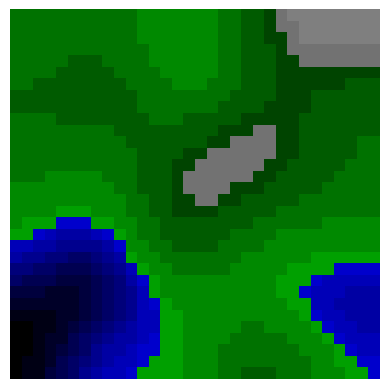

In [399]:
test_map.view_map()